# ALMA WSU Size of Compute Estimate

The goal of this notebook is to estimate the ALMA WSU size of compute. I am following the procedure in the ngVLA SoC memo (ngVLA Computing Memo #4). In that memo, the performance of a single core is measured for gridding in units of FLOPs/visibility and then that measurement is extrapolated to how many cores would be needed for a given visibility rate assuming a core efficiency, parallelization efficiency, and number of major cycles run.

I am going to run the calculation for both the BLC and WSU. The BLC case can serve as a check on the WSU numbers since we are clearly able to successfully process data for the BLC.

## Getting everything set up

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import QTable,Table, vstack
from importlib import reload
import astropy.units as u
import wsu_db
import wsu_plots
import tabulate

In [3]:
# fix up custom units
gvis = u.def_unit('Gvis',namespace=globals())
u.add_enabled_units([gvis])

In [4]:
result_c7_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle7_20230420.ecsv')
result_c8_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle8_20230420.ecsv')

In [5]:
result_mous = vstack([result_c7_mous,result_c8_mous])

In [6]:
result_mous.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_frac_bw_early','wsu_frac_bw_later_2x','wsu_frac_bw_later_4x','wsu_frac_bw_spw','nbase_typical','nbase_array','nbase_all','L80','Project','SB_name','blc_tint','blc_ntunings','bp_time','flux_

## Do I need to worry about A-projection?

ALMA currently does not correct for primary beam effects during gridding. But maybe we should.

In [7]:
def calc_aproject(result_mous):

    # set up the necessary information
    result_mous['dish_diameter'] = np.full(len(result_mous),1)
    idx = result_mous['array'] == '12m'
    result_mous['dish_diameter'][idx] = np.full(len(result_mous[idx]),12.0)
    idx = result_mous['array'] == '7m'
    result_mous['dish_diameter'][idx] = np.full(len(result_mous[idx]),7.0)
    
    # figuring whether to use aproject using criteria in ngVLA SoC memo
    result_mous['use_aproject'] = np.full(len(result_mous),False)
    result_mous['use_aproject'] = (result_mous['s_fov'].value*3600) > \
        (0.5 * (3e8 / (result_mous['wsu_freq'].value * 1e9 * result_mous['dish_diameter'])) * 206265.0)

In [8]:
calc_aproject(result_mous)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(array([   0.,    0.,    0.,    0.,    0., 5200.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

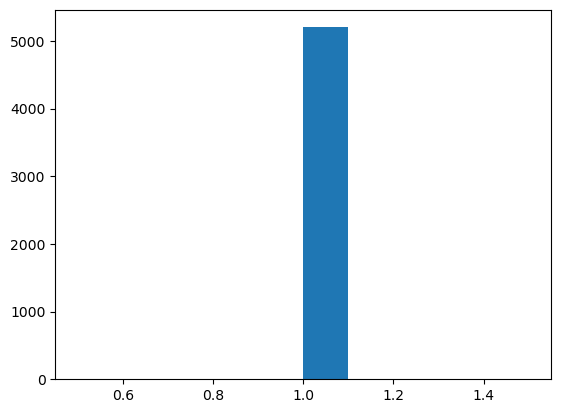

In [9]:
plt.hist(result_mous['use_aproject'])

According to this we should probably we doing A-project even though we don't.

## Add weights and system performance

In [10]:
def calc_weights_and_sysperf(mydb,
                             do_aproject = False,
                             multiscale_factor = 1.2, # default for ngVLA SoC
                             core_efficiency = 0.05, # core_efficiency; value from ngVLA SoC -- measured number
                             parallelization_efficiency = 0.8, # parallelization_efficiency; value from ngVLA SoC -- assumption
                             k = 100 # total number of major cycles over all re-runs; value from ngVLA SoC
                             ):
    '''
    Purpose: calculate the fraction of time spent for each MOUS and the required system performance

    Inputs: mydb

    Output: mydb with fractions and estimates of the required system performance

    Date        Programmer      Description of Changes
    ----------------------------------------------------------------------
    2/27/2023   A.A. Kepley     Original Code
    3/21/2023   A.A. Kepley     updated to do actual calculation rather than scale
    '''


    # flops/vis for standard convolution kernel 
    flops_per_vis_std = 1280.8  # from ngVLA SoC
    flops_per_vis_aproj = 7472.8  # from ngVLA SoC
    # ignoring w-project case for ALMA
    
    mydb['flops_per_vis'] = np.full(len(mydb), flops_per_vis_std)    

    # modify flops per vis if using a project
    if do_aproject:
        idx = mydb['use_aproject'] == True
        mydb['flops_per_vis'][idx] = np.full(len(mydb[idx]),flops_per_vis_aproj)

    # multi-scale factor
    mydb['multiscale_factor'] = np.full(len(mydb), multiscale_factor) # ngVLA SoC uses 1.2
    
    # nterms factor = 1 because we are doing cubes
    mydb['nterms_factor'] = np.ones(len(mydb))                
    
    
    # calculate system performance
    visrate_list = ['blc_visrate_typical',
                    'wsu_visrate_early_stepped2_typical',
                    'wsu_visrate_later_2x_stepped2_typical',
                    'wsu_visrate_later_4x_stepped2_typical']
    
    for visrate in visrate_list :
        outname = visrate.replace('visrate','sysperf')
        
        mydb[outname] = (mydb[visrate].value * 1e9 / 3600.0 ) *  \
            mydb['flops_per_vis'] * k * \
            mydb['multiscale_factor'] * mydb['nterms_factor'] / \
            (core_efficiency * parallelization_efficiency)

        mydb[outname]  = mydb[outname] / 1e15 # convert to PFLOPS
        

    # calculate weights
    mydb['weights_all'] = mydb['time_tot']/np.sum(mydb['time_tot'])

Assumptions:
* do_aproject = False # Not correcting for A-project
* multiscale_factor = 1.2 # Not using multiscale right now, but will likely need in the future. minor correction
* core_efficiency = 0.05 # CPU core efficiency measured by the ngVLA SoC value. GPU efficiency much higher.
* parallelization_efficiency = 0.8 # parallelization efficiency assumed from ngVLA SoC memo
* k = 20 # 2 reruns and 10 major cycles each time. Different from ngVLA SOC assumptions. Based on experience with ALMA data.


In [11]:
calc_weights_and_sysperf(result_mous,
                         do_aproject = False,
                         multiscale_factor=1.2,
                         core_efficiency=0.05,
                         parallelization_efficiency=0.8,
                         k=20)

In [12]:
result_mous.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','science_keyword','scientific_category','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_frac_bw_early','wsu_frac_bw_later_2x','wsu_frac_bw_later_4x','wsu_frac_bw_spw','nbase_typical','nbase_array','nbase_all','L80','Project','SB_name','blc_tint','blc_ntunings','bp_time','flux_

## Looking at the distribution of data rates

In [13]:
bin_max=7.5
nbin=100

In [14]:
np.max(result_mous['blc_datarate_typical'])

<Quantity 0.04583619 Gbyte / s>

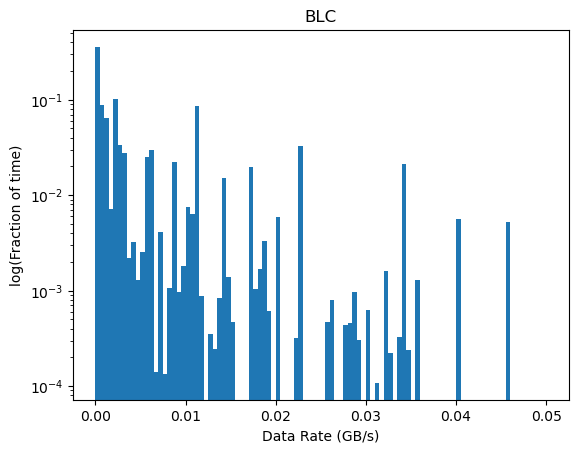

In [18]:
reload(wsu_plots)
wsu_plots.plot_datarate_result_hist(result_mous,bin_min=0,bin_max=0.05,nbin=nbin,
                              data_val='blc_datarate_typical',title='BLC')

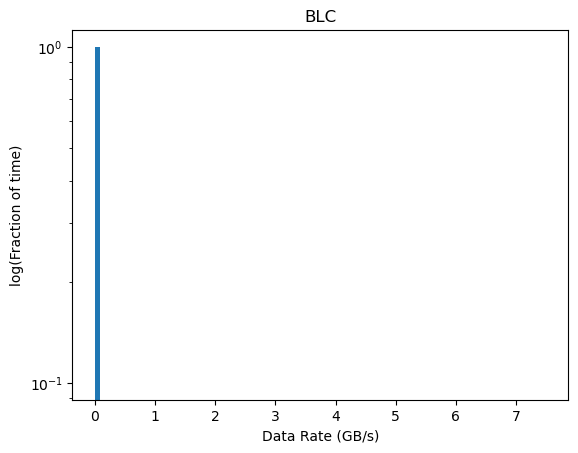

In [20]:
reload(wsu_plots)
wsu_plots.plot_datarate_result_hist(result_mous,bin_min=0,bin_max=bin_max,nbin=nbin,
                                    data_val='blc_datarate_typical',title='BLC')

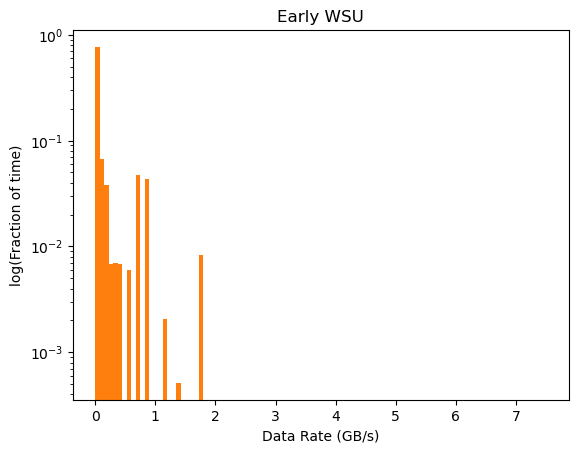

In [21]:
reload(wsu_plots)
wsu_plots.plot_datarate_result_hist(result_mous,bin_min=0,bin_max=bin_max,nbin=nbin,
                                   data_val='wsu_datarate_early_stepped2_typical',
                                   title='Early WSU')

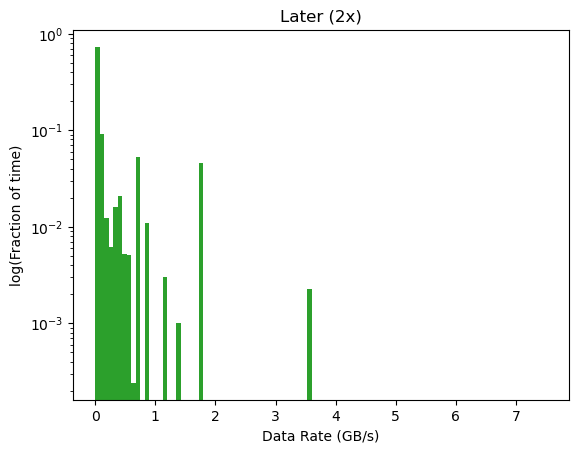

In [23]:
reload(wsu_plots)
wsu_plots.plot_datarate_result_hist(result_mous,bin_min=0,bin_max=bin_max,nbin=nbin,
                                   data_val='wsu_datarate_later_2x_stepped2_typical',
                                    title='Later (2x)')

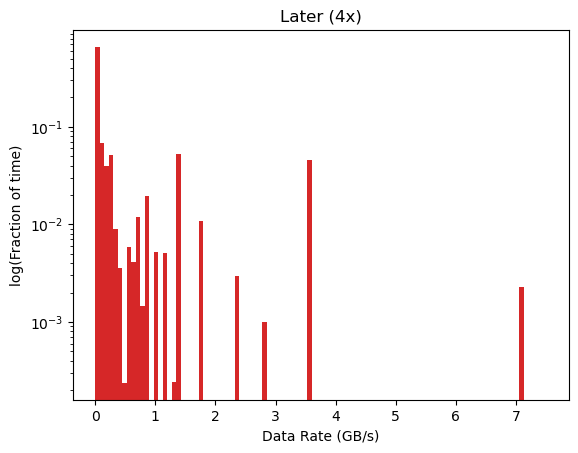

In [24]:
reload(wsu_plots)
wsu_plots.plot_datarate_result_hist(result_mous,bin_min=0,bin_max=bin_max,nbin=nbin,
                             data_val='wsu_datarate_later_4x_stepped2_typical',
                                 title='Later (4x)')

## System Performance

In [25]:
np.max(result_mous['blc_sysperf_typical'])

0.01687826041904761

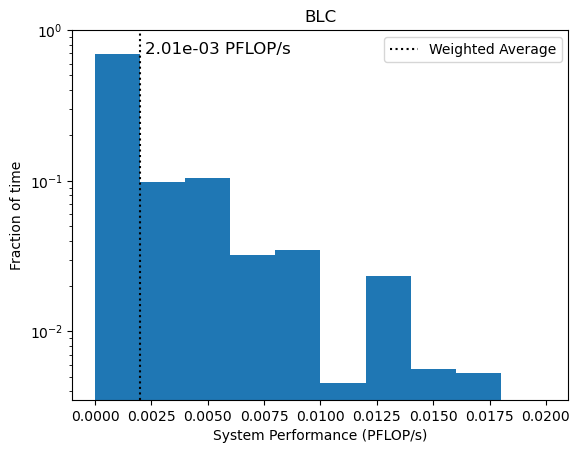

In [112]:
# all BLC data
reload(wsu_plots)
wsu_plots.plot_soc_result_hist(result_mous,bin_min=0,bin_max=0.02,
                             data_val='blc_sysperf_typical',title='BLC',add_wavg=True)

In [113]:
np.average(result_mous['blc_sysperf_typical'], weights=result_mous['weights_all'])
# PFLOPs/s

<Quantity 0.00200789>

0.002PFLOPs/s = 2 TFLOP/s

Current cluster is about 50 nodes with 40GFLOPs/node = 2TFlops total (according to Rafael).

Which matches the weighted average above!!! Granted our efficiency is less than 100% since the data sets tend to get released all at once.

But what about mitigations???

In [114]:
idx = result_mous['mitigated'] == False

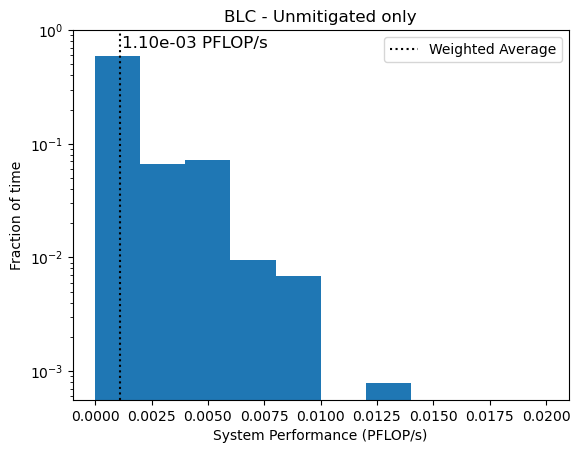

In [115]:
wsu_plots.plot_soc_result_hist(result_mous[idx],bin_min=0,bin_max=0.02,
                             data_val='blc_sysperf_typical',title='BLC - Unmitigated only',
                               add_wavg=True)

In [116]:
np.average(result_mous['blc_sysperf_typical'][idx], weights=result_mous['weights_all'][idx])

<Quantity 0.00110014>

In [117]:
np.round(np.max(result_mous['wsu_sysperf_later_4x_stepped2_typical']),1)

2.6

In [118]:
bin_max = 3.0
nbin=50

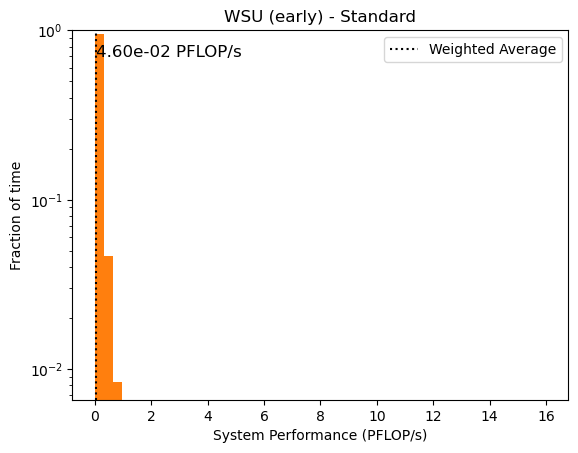

In [204]:
reload(wsu_plots)
wsu_plots.plot_soc_result_hist(result_mous,bin_min=0,bin_max=bin_max,nbin=nbin,
                               data_val='wsu_sysperf_early_stepped2_typical',
                               title='WSU (early) - Standard', add_wavg=True)

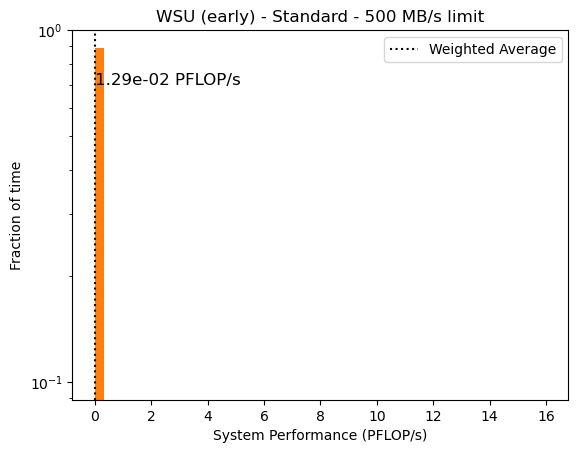

In [203]:
reload(wsu_plots)
idx = result_mous['wsu_datarate_early_stepped2_typical'] < 0.5 * u.GB /u.s
wsu_plots.plot_soc_result_hist(result_mous[idx],bin_min=0,bin_max=bin_max,nbin=nbin,
                               data_val='wsu_sysperf_early_stepped2_typical',
                               title='WSU (early) - Standard - 500 MB/s limit', add_wavg=True)

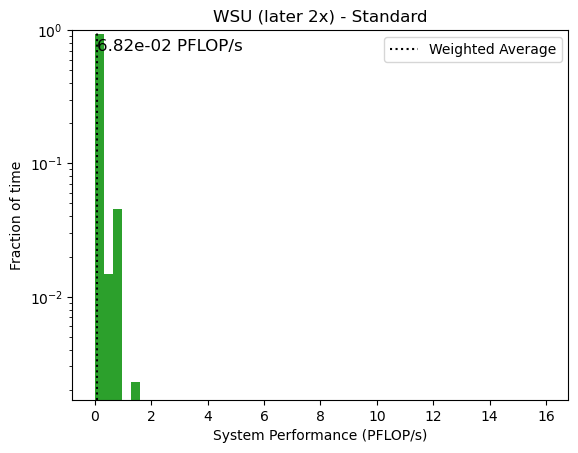

In [202]:
reload(wsu_plots)
wsu_plots.plot_soc_result_hist(result_mous,bin_min=0,bin_max=bin_max,nbin=nbin,
                             data_val='wsu_sysperf_later_2x_stepped2_typical',
                              title='WSU (later 2x) - Standard', add_wavg=True)

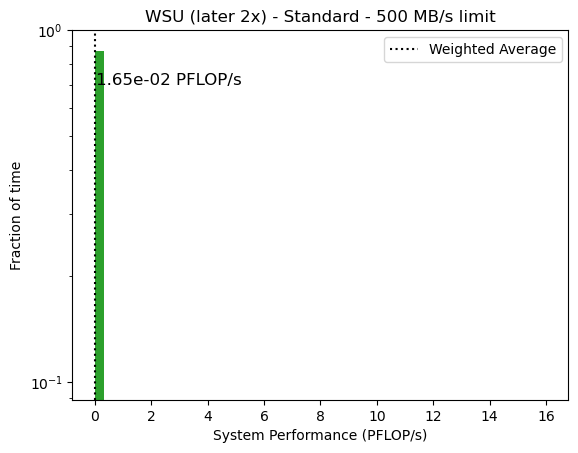

In [201]:
reload(wsu_plots)
idx = result_mous['wsu_datarate_later_2x_stepped2_typical'] < 0.5 * u.GB /u.s
wsu_plots.plot_soc_result_hist(result_mous[idx],bin_min=0,bin_max=bin_max,nbin=nbin,
                             data_val='wsu_sysperf_later_2x_stepped2_typical',
                              title='WSU (later 2x) - Standard - 500 MB/s limit', add_wavg=True)

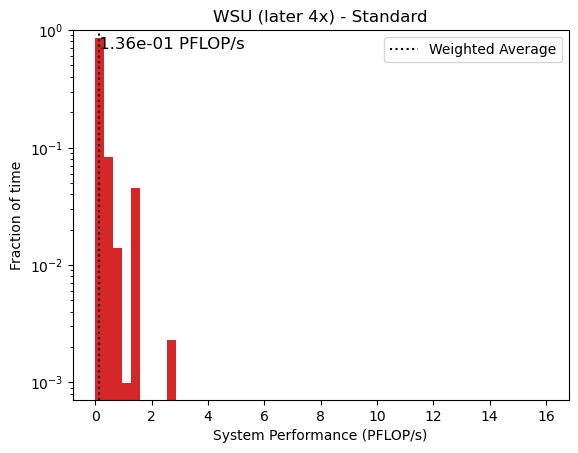

In [200]:
reload(wsu_plots)
wsu_plots.plot_soc_result_hist(result_mous,bin_min=0,bin_max=bin_max,nbin=nbin,
                             data_val='wsu_sysperf_later_4x_stepped2_typical',
                              title='WSU (later 4x) - Standard', add_wavg=True)

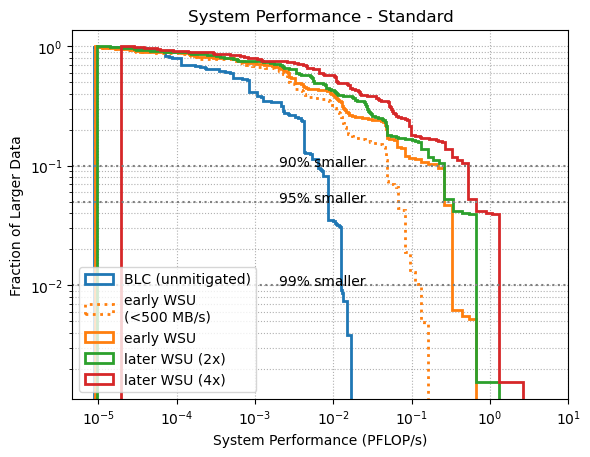

In [260]:
reload(wsu_plots)
wsu_plots.plot_soc_result_cumulative(result_mous,add_wavg=False,
                                    plot_title='System Performance - Standard',
                                    add_band2_specscan=None)

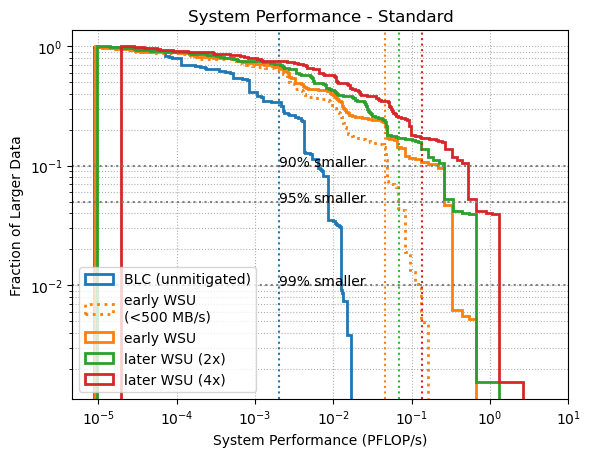

In [261]:
reload(wsu_plots)
wsu_plots.plot_soc_result_cumulative(result_mous,add_wavg=True,
                                    plot_title='System Performance - Standard',
                                    add_band2_specscan=None)

System Performance for Band 2 Spectral Scan (2x) : 0.5450271593650792
System Performance for Band 2 Spectral Scan (4x) : 0.9537975288888886


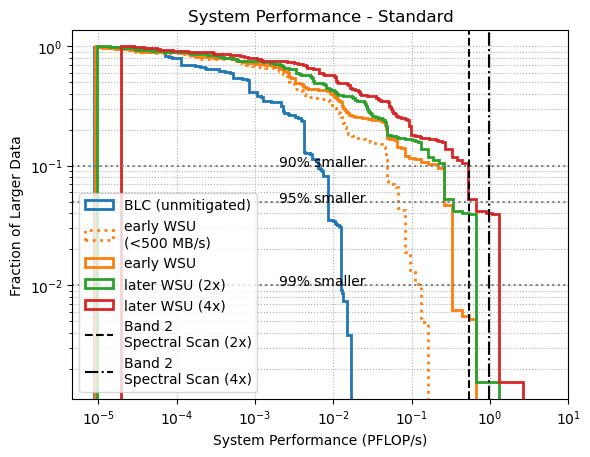

In [259]:
reload(wsu_plots)
wsu_plots.plot_soc_result_cumulative(result_mous,add_wavg=False,
                                    plot_title='System Performance - Standard',
                                    add_band2_specscan='standard')

# What if we use aproject?

In [185]:
result_mous_aproject = result_mous.copy()
calc_weights_and_sysperf(result_mous_aproject,
                         do_aproject = True,
                         multiscale_factor=1.2,
                         core_efficiency=0.05,
                         parallelization_efficiency=0.8,
                         k=20)

In [186]:
np.max(result_mous_aproject['wsu_sysperf_later_4x_stepped2_typical'])

15.196823437180948

In [187]:
bin_max=16
nbin=50

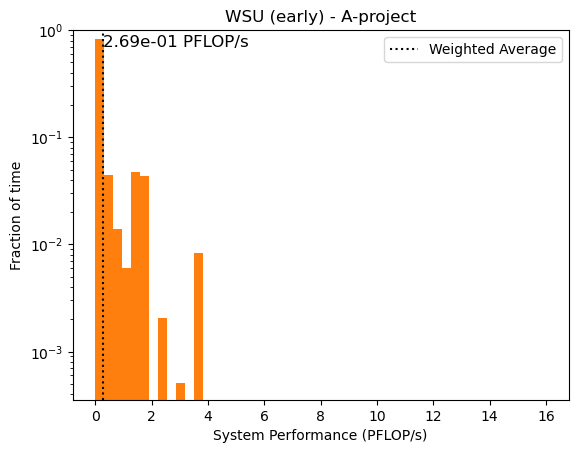

In [196]:
reload(wsu_plots)
wsu_plots.plot_soc_result_hist(result_mous_aproject,bin_min=0,bin_max=bin_max,nbin=nbin,
                             data_val='wsu_sysperf_early_stepped2_typical',
                            title='WSU (early) - A-project',
                            add_wavg=True)

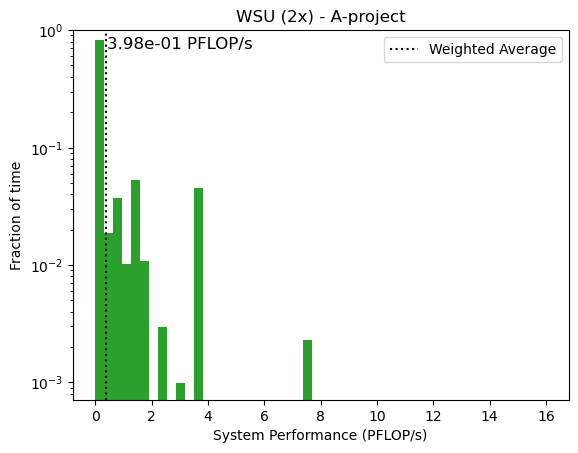

In [197]:
reload(wsu_plots)
wsu_plots.plot_soc_result_hist(result_mous_aproject,bin_min=0,bin_max=bin_max,nbin=nbin,
                             data_val='wsu_sysperf_later_2x_stepped2_typical',
                               title='WSU (2x) - A-project',
                              add_wavg=True)

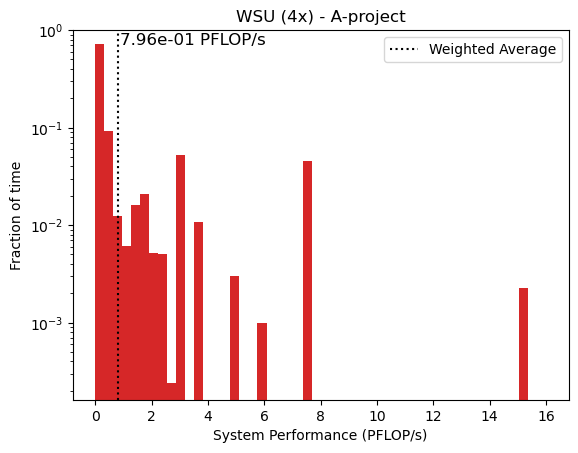

In [198]:
reload(wsu_plots)
wsu_plots.plot_soc_result_hist(result_mous_aproject,bin_min=0,bin_max=bin_max,nbin=nbin,
                             data_val='wsu_sysperf_later_4x_stepped2_typical',
                              title='WSU (4x) - A-project',
                              add_wavg=True)

System Performance for Band 2 Spectral Scan (2x) : 3.179949216507936
System Performance for Band 2 Spectral Scan (4x) : 5.564911128888888


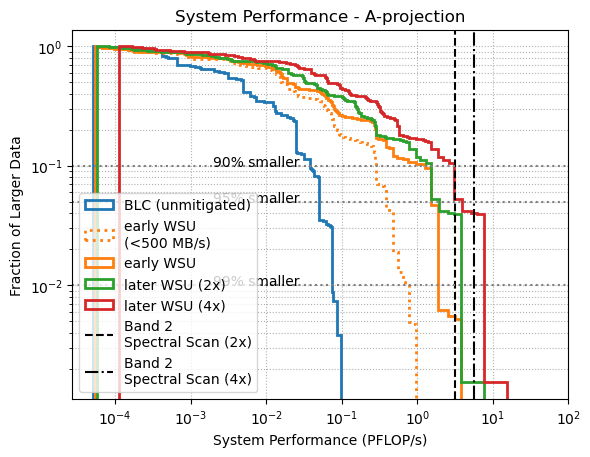

In [262]:
reload(wsu_plots)
wsu_plots.plot_soc_result_cumulative(result_mous_aproject, 
                                     plot_title='System Performance - A-projection', 
                                     add_wavg=False,
                                    add_band2_specscan='aproject')

## Table of statistics

In [60]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [61]:
# stats without aproject
mystats = Table(wsu_db.calc_wsu_sysperf_stats(result_mous))

In [62]:
mystats['median'].format = "{:7.3g}"
mystats['wavg'].format="{:7.3g}"
mystats['max'].format="{:7.3g}"

In [63]:
mystats
# UNITS = PFLOP/s

stage,median,wavg,max
str8,float64,float64,float64
blc,0.000844,0.00201,0.0169
early,0.00325,0.046,0.651
later_2x,0.0056,0.0682,1.3
later_4x,0.0112,0.136,2.6


In [64]:
# stats with aproject
mystats_aproject = Table(wsu_db.calc_wsu_sysperf_stats(result_mous_aproject))

In [65]:
mystats_aproject['median'].format = "{:7.3g}"
mystats_aproject['wavg'].format="{:7.3g}"
mystats_aproject['max'].format="{:7.3g}"

In [66]:
mystats_aproject
# UNITS = PFLOP/s

stage,median,wavg,max
str8,float64,float64,float64
blc,0.00492,0.0117,0.0985
early,0.019,0.269,3.8
later_2x,0.0327,0.398,7.6
later_4x,0.0654,0.796,15.2


## comparison to ngVLA

ngVLA max is ~750 PFLOP/s and weighted average is 50 PFLOP/s, which implies a super computer class.

Even our worst case is 50-60x smaller than this, so not supercomputer?



### IGNORE BELOW. REMINDERS TO SELF

Sanjay would like the WSU equivalent of ngVLA SoC tables 2, 3, and 7 in csv format.

Table 2:
* fraction
* dump time
* channel size
* number of channels
* image linear size
* number of baselines
* vis/hr

Table 3:
* Wcorrection - no
* PB correction=Aprojection - no (currently)
* multi-scale --  no (currently)
* multi-term -- fractional BW -- > 30%

Table 7:
* fraction
* data rate
* required system performance

What I need in final table:
* fraction
* array
* dump time
* channel size
* number of channels
* number of spws
* image linear size
* number of baselines
* vis/hr
* fractional banwidth
* multi-term
* data rate
* required system performance
